# edu-cater 

In [1]:
# imports

from selenium import webdriver
from bs4 import BeautifulSoup
import requests, os, json, csv, copy, operator
from collections import Counter

import pandas as pd
import numpy as np
import pickle, time
import seaborn as sns
from scipy.io import savemat, loadmat
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # ???
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import euclidean_distances
from pyLDAvis import sklearn as pyldavis_sklearn

import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.matutils import jaccard
from gensim.matutils import jensen_shannon

from sklearn.metrics.pairwise import cosine_similarity as cos_sim

import pyLDAvis
from pyLDAvis import gensim as pyldagensim

import networkx as nx
from networkx.algorithms import shortest_path

import warnings
warnings.filterwarnings('ignore')


# import edu-cater classes/functions
from edutools import course_scraper

[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
/home/amandae/anaconda3/envs/nibeta/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
# pipeline
run_pipeline = 0
scraper = course_scraper() 

if run_pipeline == 1:
    scraper.scrape_urls()  
    scraper.scrape_courses()
    scraper.scrape_course_network()

# Latent Dirichlet Allocation (LDA)

In [3]:
# define preprocessing functions: tokenization, stemming, lemmatization 
# based off of code from https://github.com/priya-dwivedi/Deep-Learning/blob/master/topic_modeling/LDA_Newsgroup.ipynb

stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
stopwords.extend(['youâ', 'week', 'write', 'solv', 'peer', 'assign', 'beginn',
                  'need', 'peopl', 'content', 'teach', 'assess', 'plan', 'capston',
                  'video', 'lesson', 'think', 'idea', 'lectur', 'learner'])

def lemmatize_stemming(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    stem_dict = []
    for token in gensim.utils.simple_preprocess(text) :
        if token not in stopwords and lemmatize_stemming(token) not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
            stem_dict.append((lemmatize_stemming(token), token))
            
    return result, stem_dict

In [4]:
# aggregate all text info (description, syllabus) and preprocess

# remove courses that aren't in English (even though they had an English tag!)
all_courses = np.arange(2635)
bad_courses = np.array([661, 710, 919, 925, 949, 1701, 1714, 1717, 1723, 2398, 2612])
good_courses = np.setdiff1d(all_courses, bad_courses)

processed_info = []
nreviews = []
stars = []
hours = []
levels = []
enrollment = []
course_info_all = []
titles_all = []
skills_all = []
dict_stem_full = []

for i in range(len(good_courses)): #fixthis
    if i%500 == 0:
        print(i)
    with open('course_info_short/course' + str(good_courses[i]) + '.json') as json_file:
        course_info = json.load(json_file)
    allinfo = course_info['title'] + ' ' + course_info['description'] \
            + ' ' + course_info['syllabus_headings'] + ' ' + course_info['syllabus_descriptions'] 
    tmpskills = ''
    for skill in course_info['skills']:
        allinfo = allinfo # +  ' ' + skill
        tmpskills = tmpskills + ' ' + skill
    for occupation in course_info['occupations']:
        allinfo = allinfo # + ' ' + occupation
    for review in course_info['reviews']:
        allinfo = allinfo  # + ' ' + review
    nreviews.append(course_info['nreviews'])
    stars.append(course_info['stars'])
    hours.append(course_info['hours'])
    levels.append(course_info['level'])
    enrollment.append(course_info['enrollment'])
    titles_all.append(course_info['title'])
    
    allinfo.replace('[^A-Za-z0-9]+', ' ')
    tmpskills.replace('[^A-Za-z0-9]+', ' ')
   
    preprocessed, stemdict = preprocess(allinfo)
    processed_info.append(preprocessed)
    skills_all.append(preprocess(tmpskills)[0])
    course_info_all.append(allinfo)
    dict_stem_full.extend(stemdict)
    
# save course titles for web app
file = open('edu-app/course_titles.pkl', 'wb')
pickle.dump(titles_all, file)
file.close()

# save numeric info
stars = np.array(stars)
hours = np.array(hours)
enrollment = np.array(enrollment)
savemat('edu-app/course_numeric_info.mat', {'stars': stars, 'hours': hours, 'enrollment': enrollment})


0
500
1000
1500
2000
2500


In [6]:
# make a dictionary with a) stemmed word and 
# b) lemmatized version of word most often associated with stemmed word

dict_stem_allfull = {}
for i in range(len(dict_stem_full)):
    if dict_stem_full[i][0] not in dict_stem_allfull.keys():
        dict_stem_allfull[dict_stem_full[i][0]] = []
    dict_stem_allfull[dict_stem_full[i][0]].append(dict_stem_full[i][1])
    
stemmed_words = list(dict_stem_allfull.keys())

dict_stem_maxword = {}
for stemmed in stemmed_words:
    word_counts = dict(Counter(dict_stem_allfull[stemmed]))
    maxword = max(word_counts.items(), key=operator.itemgetter(1))[0]
    dict_stem_maxword[stemmed] = WordNetLemmatizer().lemmatize(maxword, pos='v')
        

In [ ]:
# EDA for quantitative info

fig = plt.figure(figsize=(15,4))

fig.add_subplot(131)
plt.hist((np.array(stars)),20); plt.title('Rating')
fig.add_subplot(132)
plt.hist((hours),20); plt.title('Length (hours)')
fig.add_subplot(133)
plt.hist(np.log10(enrollment),20); plt.title('Enrollment (log10)')
plt.savefig('course_numeric_info.png')
plt.show()

In [5]:
# make dictionary
dictionary = gensim.corpora.Dictionary(processed_info)
print('Length of original dictionary:', len(dictionary))

# remove rare and common words
dictionary.filter_extremes(no_below=10, no_above=.25, keep_n=100000)
print('Length of filtered dictionary:', len(dictionary))

# make bag of words
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_info]

Length of original dictionary: 18839
Length of filtered dictionary: 3076


In [6]:
def get_silhouette_manual(lda_model):
    
    X = gensim.matutils.corpus2dense(bow_corpus, num_terms = len(dictionary)).T
    topic_probs = lda_model.get_document_topics(bow_corpus, minimum_probability=0)
    topic_probs_mat = np.zeros((len(topic_probs),ntopics))
    for i, doc in enumerate(topic_probs):
        for tmp_tuple in doc:
            topic_probs_mat[i, tmp_tuple[0]] = tmp_tuple[1]
    best_topics = np.argmax(topic_probs_mat,axis=1)

    centroids = np.zeros((ntopics, len(dictionary)))
    for i in range(ntopics):
        inds = np.where(best_topics==i)[0]
        centroids[i,:] = np.mean(X[inds,:],axis=0)

    dissim_docs = euclidean_distances(X)
    dissim_centroids = euclidean_distances(X, centroids)
    
    silhouette_all = []
    for doc in range(len(good_courses)):
        topic = best_topics[doc]
        inds_same = np.where(best_topics==topic)[0]
        dissim_same = dissim_docs[doc,inds_same]
        max_dist = np.max(dissim_same)

        inds_diff = np.setdiff1d(np.arange(ntopics), topic)
        dissim_diff = dissim_centroids[doc, inds_diff]
        min_dist = np.min(dissim_diff)

        silhouette = np.divide(min_dist - max_dist, np.max([min_dist, max_dist]))
        silhouette_all.append(silhouette)
        
        return silhouette_all
    

def get_silhouette(lda_model):
    X = gensim.matutils.corpus2dense(bow_corpus, num_terms = len(dictionary)).T
    topic_probs = lda_model.get_document_topics(bow_corpus, minimum_probability=0)
    topic_probs_mat = np.zeros((len(topic_probs),ntopics))
    for i, doc in enumerate(topic_probs):
        for tmp_tuple in doc:
            topic_probs_mat[i, tmp_tuple[0]] = tmp_tuple[1]
    best_topics = np.argmax(topic_probs_mat,axis=1)
    return silhouette_score(X, best_topics)

def get_course_skills_scores(ind): 
    
    unseen_document = course_info_all[ind]
    bow_vector = dictionary.doc2bow(preprocess(unseen_document)[0])
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
        
    course_topic_scores = topic_scores
        
    unseen_document = skills_all[ind]
    bow_vector = dictionary.doc2bow(unseen_document)
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
        
    skills_topic_scores = topic_scores
        
    return course_topic_scores, skills_topic_scores


def get_course_skills_sim(lda_model):
    course_skills_sim = []
    topterms_in_skills = []
    for i in range(len(skills_all)):
        if i%500 == 0:
            print(i)

        # not all courses have skills tags
        if len(skills_all[i])>0:
            ind = i
            course_scores, skills_scores = get_course_skills_scores(ind)
            cs_sim = cos_sim(course_scores, skills_scores)[0][0]
            course_skills_sim.append(cs_sim)

            skills = set(skills_all[i])
            best_topic = np.argmax(course_scores)
            topic_terms = lda_model.get_topic_terms(best_topic, topn=30)
            top_terms = []
            for x in range(len(topic_terms)):
                top_terms.append(dictionary[topic_terms[x][0]])

            counter = 0
            for term in top_terms:
                if term in skills:
                    counter +=1
            topterms_in_skills.append(counter)
        
    return course_skills_sim, topterms_in_skills


def get_jensen_shannon(lda_model):
    topic_dists = lda_model.get_topics()
    js_dists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i>j:
                js_dists.append(jensen_shannon(topic_dists[i,:], topic_dists[j,:]))
                
    return np.min(js_dists), np.mean(js_dists)

def get_jaccard(model):
    topn = int(np.ceil(len(dictionary)*(10/100)))
    jdists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i > j:        
                topic_terms = lda_model.get_topic_terms(i, topn=topn)
                top_terms1 = []
                for x in range(len(topic_terms)):
                    top_terms1.append(dictionary[topic_terms[x][0]])
                topic_terms = lda_model.get_topic_terms(j, topn=topn)
                top_terms2 = []
                for x in range(len(topic_terms)):
                    top_terms2.append(dictionary[topic_terms[x][0]])

                jdists.append(jaccard(top_terms1, top_terms2))
    return np.min(jdists), np.mean(jdists)

In [7]:
# this is how pcoa works in pyldavis

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

def pcoa(lda_model, n_components=2):
    
    topic_dists = lda_model.get_topics()
    pair_dists = np.zeros((ntopics, ntopics))
    for i in range(ntopics):
        for j in range(ntopics):
            pair_dists[i,j] = jensen_shannon(topic_dists[i,:], topic_dists[j,:])

    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1][:n_components]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)

    pcoa_mat = np.sqrt(eigvals) * eigvecs
    pcoa_dist = euclidean_distances(pcoa_mat)
    
    mask = np.zeros_like(pcoa_dist, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    uptri_dists = np.triu(pcoa_dist)
    uptri_dists = uptri_dists[uptri_dists>0]
    return np.min(uptri_dists), np.mean(uptri_dists)
    

# determine optimal # of topics

In [36]:
myseed=0
lda_model =  LdaMulticore(bow_corpus, num_topics = 12, id2word = dictionary,
                          random_state = myseed, passes = 10, workers = 2, iterations=300)

In [22]:
# run LDA model for different # of topics and calculate coherence

ntopics_list = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
ntopics_list = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
myseed = 2

coherence_all_cv = []
coherence_all_umass = []
perplexity_all = []
jsdists_min = []
jdists_min = []
jsdists_mean = []
jdists_mean = []
course_skills_sim = []
silhouette_all = []
pcoa_min = []
pcoa_mean = []

for ntopics in ntopics_list:
    print(ntopics)
    lda_model =  LdaMulticore(bow_corpus, num_topics = ntopics, id2word = dictionary,
                              random_state = myseed, passes = 10, workers = 2, iterations=300)
    #cm = CoherenceModel(model=lda_model, texts=processed_info, corpus=bow_corpus, coherence='c_v', topn=308)
    #coherence_all_cv.append(cm.get_coherence())
    #cm = CoherenceModel(model=lda_model, texts=processed_info, corpus=bow_corpus, coherence='u_mass', topn=308)
    #coherence_all_umass.append(cm.get_coherence())
    #perplexity_all.append(lda_model.log_perplexity(bow_corpus))
    jsdists_min.append(get_jensen_shannon(lda_model)[0])
    jdists_min.append(get_jaccard(lda_model)[0])
    jsdists_mean.append(get_jensen_shannon(lda_model)[1])
    jdists_mean.append(get_jaccard(lda_model)[1])
    pcoa_min.append(pcoa(lda_model)[0])
    pcoa_mean.append(pcoa(lda_model)[1])
    course_skills_sim.append(np.median(get_course_skills_sim(lda_model)[0]))
    #silhouette_all.append(get_silhouette_manual(lda_model))

savename = 'coherence_' + str(myseed) + '.pkl'
file = open(savename,'wb')
pickle.dump([coherence_all_cv, coherence_all_umass, perplexity_all, jsdists_min, jdists_min, jsdists_mean, jdists_mean, pcoa_min, pcoa_mean, course_skills_sim, silhouette_all, ntopics_list], file)
file.close()

10
0
500
1000
1500
2000
2500
11
0
500
1000
1500
2000
2500
12
0
500
1000
1500
2000
2500
13
0
500
1000
1500
2000
2500
14
0
500
1000
1500
2000
2500
15
0
500
1000
1500
2000
2500
16
0
500
1000
1500
2000
2500
17
0
500
1000
1500
2000
2500
18
0
500
1000
1500
2000
2500
19
0
500
1000
1500
2000
2500
20
0
500
1000
1500
2000
2500


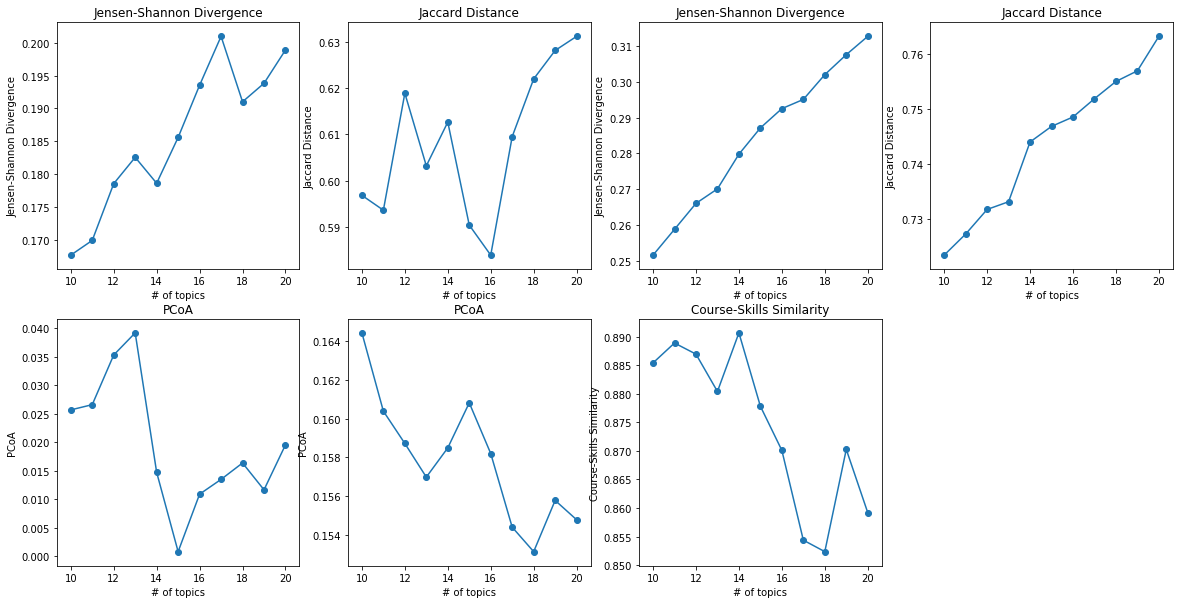

In [106]:
# plot coherence vs # of topics
myseed=0
savename = 'coherence_' + str(myseed) + '.pkl'
file = open(savename,'rb')
coherence_all_cv, coherence_all_umass, perplexity_all, jsdists_min, jdists_min, jsdists_mean, jdists_mean, pcoa_min, pcoa_mean, course_skills_sim, silhouette_all, ntopics_list = pickle.load(file)
file.close()

fig = plt.figure(figsize=(20,10))

#metrics = [coherence_all_cv, coherence_all_umass, perplexity_all, jsdists_all, jdists_all, course_skills_sim, silhouette_all]
#metric_names = ['Coherence (CV)', 'Coherence (umass)', 'Perplexity', 'Jensen-Shannon Divergence', 'Jaccard Distance', 'Course-Skills Similarity','Silhouette']

metrics = [jsdists_min, jdists_min, jsdists_mean, jdists_mean, pcoa_min, pcoa_mean, course_skills_sim]
metric_names = ['Jensen-Shannon Divergence','Jaccard Distance', 'Jensen-Shannon Divergence','Jaccard Distance', 'PCoA', 'PCoA', 'Course-Skills Similarity']


for p in range(len(metrics)):
    fig.add_subplot(2,4,p+1)
    plt.plot(ntopics_list, metrics[p])
    plt.scatter(ntopics_list, metrics[p])
    plt.xlabel('# of topics')
    plt.ylabel(metric_names[p])
    plt.title(metric_names[p])

    
    

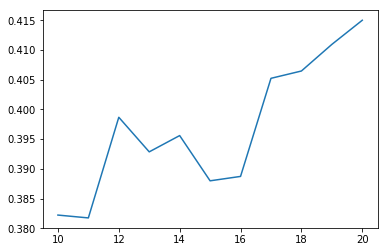

In [111]:
avg_score = np.zeros((len(ntopics_list),1))
for metric in metrics:
    avg_score += np.array(metric).reshape(-1,1)

avg_score /= len(metrics)

plt.plot(ntopics_list,(np.array(jsdists_min)+np.array(jdists_min))/2)

In [131]:
countvec = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=.25, min_df=10)
clean_text = [' '.join(text) for text in processed_info]
X_countvec = countvec.fit_transform(clean_text).todense()

model = LatentDirichletAllocation(n_components=50, random_state=0) #max_doc_update_iter=500, 
model.fit_transform(X_countvec) # or just "fit"?

X = X_countvec
topic_probs_mat = model.transform(X_countvec)
best_topics = np.argmax(topic_probs_mat,axis=1)
centroids = model.components_
silhouette_score(X_countvec, best_topics)

-0.06664296313416168

In [116]:
lda_method = 'gensim'

if lda_method == 'gensim':
    X = gensim.matutils.corpus2dense(bow_corpus, num_terms = len(dictionary)).T
    topic_probs = lda_model.get_document_topics(bow_corpus, minimum_probability=0)
    topic_probs_mat = np.zeros((len(topic_probs),ntopics))
    for i, doc in enumerate(topic_probs):
        for tmp_tuple in doc:
            topic_probs_mat[i, tmp_tuple[0]] = tmp_tuple[1]
    best_topics = np.argmax(topic_probs_mat,axis=1)
    centroids = lda_model.get_topics()
elif lda_method == 'sklearn':
    X = X_countvec
    topic_probs_mat = model.transform(X_countvec)
    best_topics = np.argmax(topic_probs_mat,axis=1)
    # centroids = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    centroids = model.components_

dist_docs = euclidean_distances(X)
dist_docs_centroids = euclidean_distances(X, centroids)
dist_centroids = euclidean_distances(centroids)

dist_docs = 1 - cos_sim(X)
dist_docs_centroids = 1 - cos_sim(X, centroids)
dist_centroids = 1 - cos_sim(centroids)

silhouette_all = []
for doc in range(len(good_courses)):
    topic = best_topics[doc]
    inds_same = np.where(best_topics==topic)[0]
    dist_same = dist_docs[doc,inds_same]
    dist_a = np.mean(dist_same)

    closest_topic = np.argmin(dist_centroids[topic,:])
    inds_diff = np.where(best_topics==closest_topic)[0]
    dist_diff = dist_docs[doc, inds_diff]
    dist_b = np.mean(dist_diff)

    silhouette = np.divide(dist_b - dist_a, np.max([dist_b, dist_a]))
    silhouette_all.append(silhouette)
    
    
silhouette_all = []
for topic in range(ntopics):
    inds_same = np.where(best_topics==topic)[0]
    dist_same = dist_docs[doc,inds_same]
    dist_a = np.mean(dist_same)

    diff_topics = np.setdiff1d(np.arange(ntopics), topic)
    closest_topic = np.argmin(dist_centroids[topic,diff_topics])
    inds_diff = np.where(best_topics==closest_topic)[0]
    dist_diff = dist_docs[doc, inds_diff]
    dist_b = np.mean(dist_diff)

    silhouette = np.divide(dist_b - dist_a, np.max([dist_b, dist_a]))
    silhouette_all.append(silhouette)
        

In [45]:
# re-define model using optimal # of topics, and print topics

from gensim.models import TfidfModel
tfidf_model = TfidfModel(bow_corpus)  # fit model
tfidf_list = tfidf_model[bow_corpus]

ntopics = 12
myseed = 0 

lda_model =  gensim.models.LdaMulticore(bow_corpus, num_topics = ntopics, id2word = dictionary, 
                                        random_state=myseed, passes = 10, workers = 2, iterations=300)

#for idx, topic in lda_model.print_topics(-1):
#    print("Topic: {} \nWords: {}".format(idx, topic ))
#    print("\n")

In [43]:
# interactive visualization of topics with pyLDAvis

pyLDAvis.enable_notebook()
data = pyldagensim.prepare(lda_model, tfidf_list, dictionary,sort_topics=False)

# fix terms to be lemmatized most commonword instead of stemmed word
for row in range(len(data.topic_info.index)):
    if row%10 == 0:
        print(row)
    maxword = dict_stem_maxword[data.topic_info["Term"].iloc[row]]
    data.topic_info["Term"].iloc[row] = maxword
pyLDAvis.save_html(data,'edu-app/static/courseviz.html')
pyLDAvis.display(data)

# data.topic_coordinates

0


NameError: name 'dict_stem_maxword' is not defined

# Uniqueness of topics

Use Jensen-Shannon divergence and Jaccard distance to determine how unique the topics are.

In [46]:
# jensen shannon distance
jaccard_dists = np.zeros((ntopics,ntopics))
js_dists = np.zeros((ntopics,ntopics))
topic_dists = lda_model.get_topics()
for i in range(ntopics):
    for j in range(ntopics):
        js_dists[i,j] = jensen_shannon(topic_dists[i,:], topic_dists[j,:])
        
        
# jaccard
jdists = np.zeros((ntopics,ntopics))
topn = int(np.ceil(len(dictionary)*(10/100)))
for i in range(ntopics):
    topic_terms = lda_model.get_topic_terms(i, topn=topn)
    top_terms1 = []
    for x in range(len(topic_terms)):
        top_terms1.append(dictionary[topic_terms[x][0]])
    for j in range(ntopics):
        topic_terms = lda_model.get_topic_terms(j, topn=topn)
        top_terms2 = []
        for x in range(len(topic_terms)):
            top_terms2.append(dictionary[topic_terms[x][0]])    
        jdist = jaccard(top_terms1, top_terms2)
        jdists[i,j] = jdist

Median Jaccard distance: 0.7325102880658436
Median JS distance: 0.26495763659477234


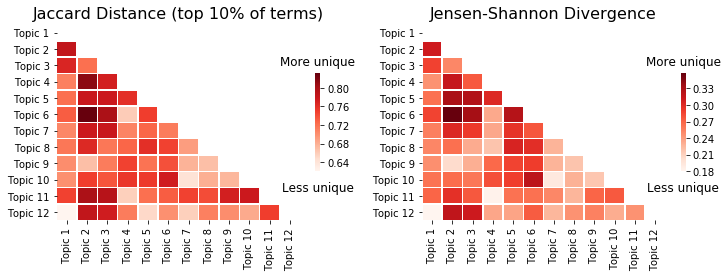

In [65]:
# plots

mask = np.zeros_like(jdists, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

uptri_jdists = np.triu(jdists)
uptri_jdists = uptri_jdists[uptri_jdists>0]
print('Median Jaccard distance:', np.median(uptri_jdists))


uptri_js_dists = np.triu(js_dists)
uptri_js_dists = uptri_js_dists[uptri_js_dists>0]
print('Median JS distance:', np.median(uptri_js_dists))


def label_cbar(ax):
    cb = ax.collections[0].colorbar
    cb.ax.text(0.5, -0.1, 'Less unique', transform=cb.ax.transAxes, 
        va='top', ha='center', fontsize=12)
    cb.ax.text(0.5, 1.05, 'More unique', transform=cb.ax.transAxes, 
        va='bottom', ha='center', fontsize=12)

fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
ax = sns.heatmap(jdists, mask=mask, cmap='Reds', vmin=np.round(np.min(uptri_jdists),2),
            linewidths=.5, cbar_kws={"shrink": .5})
tick_labels = ['Topic ' + str(topic) for topic in np.arange(ntopics)+1]
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticklabels(tick_labels, rotation=0)
label_cbar(ax)
plt.title('Jaccard Distance (top 10% of terms)',fontsize=16)

fig.add_subplot(122)
ax = sns.heatmap(js_dists, mask=mask, cmap='Reds', vmin=np.round(np.min(uptri_js_dists),2),
            linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticklabels(tick_labels, rotation=0)
label_cbar(ax)
plt.title('Jensen-Shannon Divergence', fontsize=16)

plt.gcf().subplots_adjust(bottom=.2)
plt.savefig('topic_uniqueness.png')
plt.show()


# Similarity between topic scores

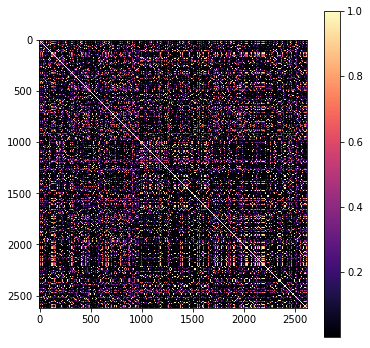

In [8]:
# similarity b/w topic scores 
    
topic_probs = lda_model.get_document_topics(bow_corpus, minimum_probability=0)
scoremat = np.zeros((len(topic_probs),ntopics))
for i, doc in enumerate(topic_probs):
    for tmp_tuple in doc:
        scoremat[i, tmp_tuple[0]] = tmp_tuple[1]
    
savemat('edu-app/scoremat.mat',{'scoremat': scoremat})

scorecorrs = cos_sim(scoremat)

fig = plt.figure(figsize=(6,6))
plt.imshow(scorecorrs, cmap='magma')
plt.colorbar()
plt.show()

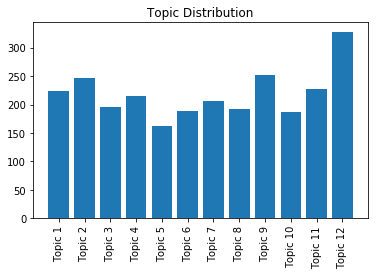

In [12]:
# distribution of best-matching topics

bestmatch = np.argmax(scoremat,axis=1)
freqs = np.histogram(bestmatch, ntopics)[0]
plt.bar(np.arange(ntopics)+1, freqs)
my_x_labels = []
for x in range(ntopics):
    my_x_labels.append('Topic ' + str(x+1))
plt.xticks(np.arange(ntopics)+1,my_x_labels, rotation=90)
plt.gcf().subplots_adjust(bottom=0.20)
plt.title('Topic Distribution')
plt.savefig('topicdist.png')
plt.show()

# Graph theory with networkx

0.7182026421942943
min strength: 10.120273866559403


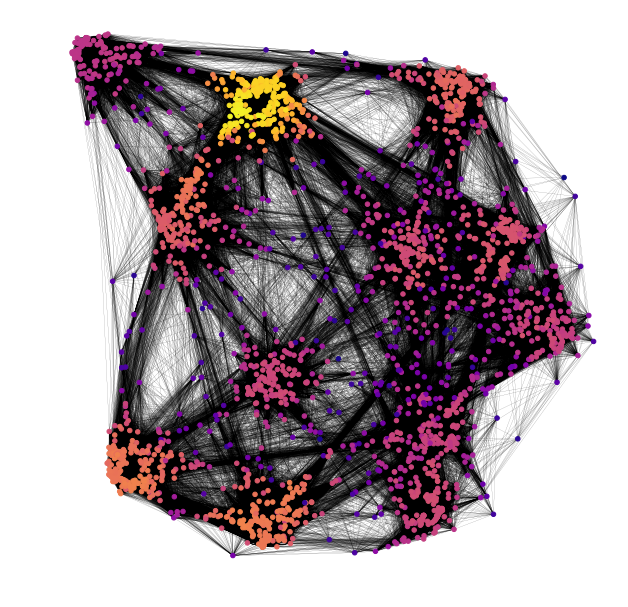

In [87]:
# graph theory with networkx

scorecorrs = cos_sim(scoremat)
scorecorrs_triu = np.triu(scorecorrs)
scorecorrs_triu = scorecorrs_triu[scorecorrs_triu>0]
thresh = np.percentile(scorecorrs_triu,92.5)
print(thresh)
# thresh=.7
scorecorrs[scorecorrs<=thresh] = 0

strength = np.sum(scorecorrs,0)
print('min strength:', np.min(strength))

G = nx.from_numpy_matrix(scorecorrs)
pos = nx.spring_layout(G)
weights = dict(G.degree(weight='weight'))
values = [weights.get(node, 0.25) for node in G.nodes()]
values_lda = copy.deepcopy(values)

file = open('edu-app/networkx_graph.pkl','wb')
pickle.dump(G, file)
file.close()

file = open('edu-app/networkx_pos.pkl', 'wb')
pickle.dump(pos, file)
file.close()

file = open('edu-app/networkx_values.pkl', 'wb')
pickle.dump(values, file)
file.close()

with open('edu-app/static/nodes_orig.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x', 'y', 'strength', 'radius','title'])
    for i in range(len(pos)):
        fwriter.writerow([pos[i][0], pos[i][1], int(values[i]), 2, titles_all[i]])

plt.figure(1,figsize=(8,8)) 
nx.draw(G, pos, node_size=20, node_color = values, width=.1, cmap='plasma')
plt.savefig("coursera_lda_network.png", format="PNG")
plt.show(block=False)

# write edges.csv: saved edges are for visualization only (higher threshold)
list_edges = list(G.edges())
with open('edu-app/static/edges_orig.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x1', 'x2', 'y1', 'y2', 'width', 'color'])
    for i in range(len(list_edges)):
        if list_edges[i][0] != list_edges[i][1]:
            x1 = pos[list_edges[i][0]][0]
            x2 = pos[list_edges[i][1]][0]
            y1 = pos[list_edges[i][0]][1]
            y2 = pos[list_edges[i][1]][1]
            fwriter.writerow([x1, x2, y1, y2, G.edges[list_edges[i][0],list_edges[i][1]]['weight'], '#000000'])

/home/amandae/anaconda3/envs/nibeta/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


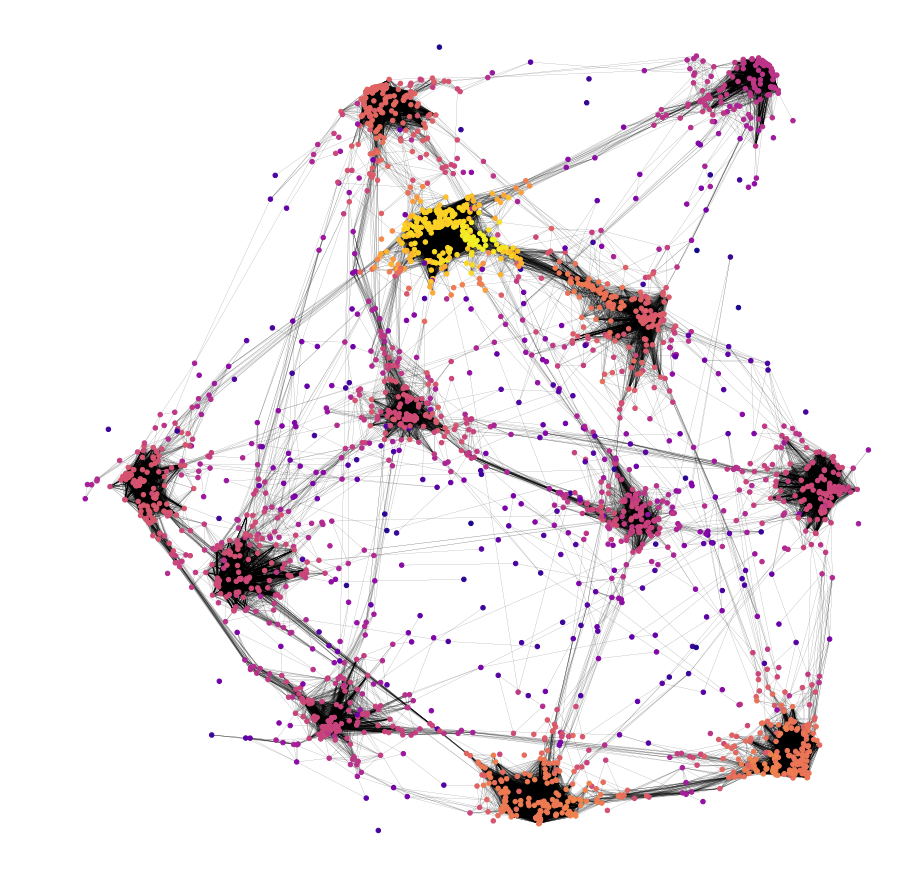

In [12]:
# threshold for viz purposes

thresh = np.percentile(scorecorrs_triu,97.5)
scorecorrs[scorecorrs<=thresh] = 0
G = nx.from_numpy_matrix(scorecorrs)

plt.figure(1,figsize=(12,12)) 
nx.draw(G, pos, node_size=20, node_color = values, width=.1, cmap='plasma')
plt.savefig("coursera_lda_network.png", format="PNG")
plt.show(block=False)

# write edges.csv: saved edges are for visualization only (higher threshold)
list_edges = list(G.edges())
with open('edu-app/static/edges_orig_plot.csv', mode='w') as fp:
    fwriter = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    fwriter.writerow(['x1', 'x2', 'y1', 'y2', 'width', 'color'])
    for i in range(len(list_edges)):
        if list_edges[i][0] != list_edges[i][1]:
            x1 = pos[list_edges[i][0]][0]
            x2 = pos[list_edges[i][1]][0]
            y1 = pos[list_edges[i][0]][1]
            y2 = pos[list_edges[i][1]][1]
            fwriter.writerow([x1, x2, y1, y2, G.edges[list_edges[i][0],list_edges[i][1]]['weight'], '#000000'])

# Validate the LDA model

## compare to coursera's recommendation graph

In [ ]:
# make binary graph: rows = course being viewed; cols = courses that are recommended
ncourses = len(titles_all)
coursenet_full = np.zeros((ncourses,ncourses))
for i in range(ncourses):
    mat = loadmat('course_nets/course'+str(good_courses[i])+'.mat')
    coursenet = mat['coursenet']
    coursenet = coursenet[:,good_courses][0]
    coursenet_full[i,:] = coursenet
    inds = np.where(coursenet_full[i,:]==1.0)[0]
    
    
# topic-topic similarity for courses that are recommended by coursera
coursenet_sim = np.zeros((ncourses,ncourses))
for i in range(ncourses):
    for j in range(ncourses):
        scores1 = scoremat[i,:]
        scores2 = scoremat[j,:]
        if coursenet_full[i,j] == 1:
            coursenet_sim[i,j] = cos_sim(scores1[:,np.newaxis].T,scores2[:,np.newaxis].T)[0][0]
            

231


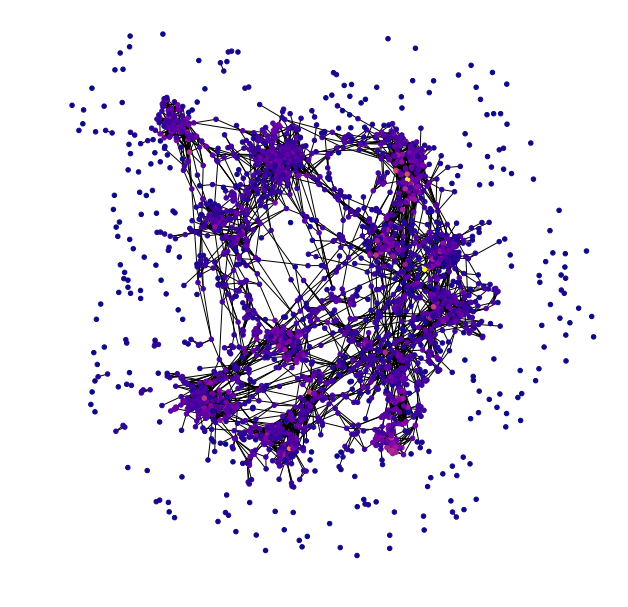

In [88]:
thresh = np.percentile(scorecorrs_triu,92.5)
coursenet_thresh = copy.deepcopy(coursenet_sim)
coursenet_thresh[coursenet_thresh<=thresh] = 0
#coursenet_thresh[coursenet_thresh>thresh] = 1

G = nx.from_numpy_matrix(coursenet_thresh)
nx.from_numpy_matrix
weights = dict(G.degree(weight='weight'))
values = np.array([weights.get(node, 0.25) for node in G.nodes()])
values_recs = copy.deepcopy(values)
print(np.sum(values==0))
file = open('edu-app/networkx_pos.pkl','rb')
pos = pickle.load(file)
file.close()

pos_new = nx.spring_layout(G, pos=pos, iterations=5, seed=100)

plt.figure(1,figsize=(8, 8)) 
nx.draw(G, pos_new, node_size=20, node_color=values, width=1, cmap='plasma')
plt.savefig("coursera_rec_network.png", format="PNG")
plt.show(block=False)

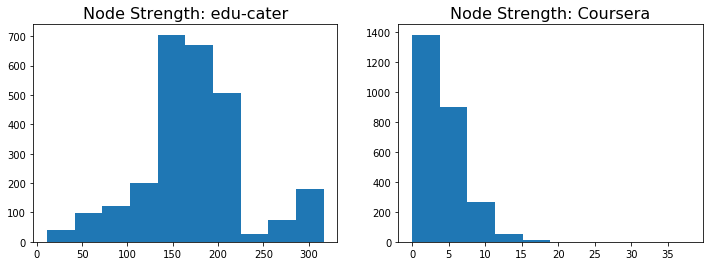

In [95]:
# compare node strength for lda and orig recs

fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.hist(values_lda)
plt.title('Node Strength: edu-cater', fontsize=16)
fig.add_subplot(122)
plt.hist(values_recs)
plt.title('Node Strength: Coursera', fontsize=16)
plt.savefig('node_strength.png')
plt.show()

## How is the LDA model better than Coursera's current recommendation system?

1) The cosine similarity between topic scores for a document (used to train the model) and topic scores from skills tags (not used in model training) is high. Thus, the topics generated from LDA are valid.  

2) However, for a given course, the overlap between the skills tags and the top 10 terms from the most relevant topic is low (max 4/10). Thus, the topics provide more information than the skills tags alone.  

These features are demonstrated with the code below.

In [54]:
def get_course_skills_scores(ind): 
    
    unseen_document = course_info_all[ind]
    bow_vector = dictionary.doc2bow(preprocess(unseen_document)[0])
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
        
    course_topic_scores = topic_scores
        
    unseen_document = skills_all[ind]
    bow_vector = dictionary.doc2bow(unseen_document)
    topic_tuples = lda_model.get_document_topics(bow_vector, 0, 0, True)[0]
    topic_scores = np.zeros((1, len(topic_tuples)))
    for i, score in enumerate(topic_tuples):
        topic_scores[0,i] = score[1]
        
    skills_topic_scores = topic_scores
        
    return course_topic_scores, skills_topic_scores

course_skills_sim = []
topterms_in_skills = []


def get_course_skills_sim():
    for i in range(len(skills_all)):
        if i%100 == 0:
            print(i)

        # not all courses have skills tags
        if len(skills_all[i])>0:
            course_scores, skills_scores = get_course_skills_scores(i)
            cs_sim = cos_sim(course_scores, skills_scores)[0][0]
            course_skills_sim.append(cs_sim)

            skills = set(skills_all[i])
            best_topic = np.argmax(course_scores)
            topic_terms = lda_model.get_topic_terms(best_topic, topn=30)
            top_terms = []
            for x in range(len(topic_terms)):
                top_terms.append(dictionary[topic_terms[x][0]])

            counter = 0
            for term in top_terms:
                if term in skills:
                    counter +=1
            topterms_in_skills.append(counter)
        
    return topterms_in_skills
    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


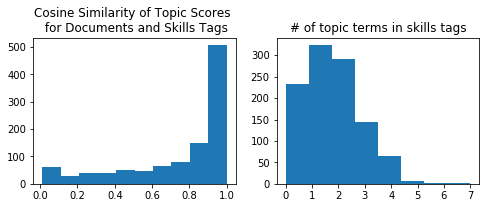

1069 courses had skills tags
Median similarity between document scores and topic scores: 0.8869723091885734
Median number of skills tag terms present in top 10 terms: 1.0


In [67]:
# plots to show similarity and overlap

fig = plt.figure(figsize=(8,3))
fig.add_subplot(121); plt.hist(course_skills_sim); 
plt.title('Cosine Similarity of Topic Scores \n for Documents and Skills Tags')
fig.add_subplot(122); plt.hist(topterms_in_skills,np.max(topterms_in_skills)+1);
plt.xticks(np.arange(np.max(topterms_in_skills)+1))
plt.title('# of topic terms in skills tags')
plt.gcf().subplots_adjust(top=.80)
plt.savefig('validation1.png')
plt.show()
print(len(course_skills_sim), 'courses had skills tags')
print('Median similarity between document scores and topic scores:',np.median(course_skills_sim))
print('Median number of skills tag terms present in top 10 terms:',np.median(topterms_in_skills))

# testing with sklearn

In [8]:
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=.25, min_df=10)
clean_text = [' '.join(text) for text in processed_info]
X = tfv.fit_transform(clean_text).todense()
featnames = tfv.get_feature_names()

countvec = CountVectorizer(ngram_range=(1,1), stop_words=stopwords, max_df=.25, min_df=10)
clean_text = [' '.join(text) for text in processed_info]
X = countvec.fit_transform(clean_text).todense()

In [43]:
model = LatentDirichletAllocation(n_components=12, random_state=1)
model.fit(X) # or  "fit_transform"?

topic_probs_mat = model.transform(X)
components = 
model.components_

(12, 3076)

In [90]:
ntopics=12
def get_jensen_shannon(components, ntopics):
    #topic_dists = lda_model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topic_dists = components 
    js_dists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i>j:
                js_dists.append(jensen_shannon(topic_dists[i,:], topic_dists[j,:]))
                
    return np.min(js_dists), np.mean(js_dists)

def get_jaccard(components, ntopics):
    topn = int(np.ceil(len(dictionary)*(10/100)))
    topic_word_probs = components #/ model.components_.sum(axis=1)[:, np.newaxis]
    top_terms = np.argsort(-1*topic_word_probs,axis=1)
    top_terms = -1*top_terms[:,0:topn]
    jdists = []
    for i in range(ntopics):
        for j in range(ntopics):
            if i > j:   
                jdists.append(jaccard(top_terms[i,:], top_terms[j,:]))
    return np.min(jdists), np.mean(jdists)

In [94]:
def avg_score(components, ntopics, ytrue=None):
    score1 = get_jensen_shannon(components, ntopics)[0]
    score2 = get_jaccard(components, ntopics)[0]
    return (score1 + score2)/2

In [128]:
class LDAwithCustomScore(LatentDirichletAllocation):
    def score(self, X, y=None):
        # You can change the options passed to perplexity here
        #score = avg_score(super(LDAwithCustomScore, self))
        components = self.components_
        ntopics = self.n_components
        score = get_jensen_shannon(components, ntopics)[0]
        return score
    

In [114]:
#model1 = LatentDirichletAllocation(n_components=10)
#model1.fit(X)
get_jensen_shannon(model1.components_,model1.n_components)

(0.26706858740481587, 0.349578989288483)

In [140]:
# grid search CV with pipeline

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# Define Search Param
ntopics_list = [21, 22, 23, 24, 25]
search_params = {'n_components': ntopics_list}
lda = LDAwithCustomScore()

model = GridSearchCV(lda, param_grid=search_params, cv=10)
model.fit(X)

# Best Model
best_lda_model = model.best_estimator_

file = open('sklearn_model3.pkl', 'wb')
pickle.dump(model,file)
file.close()

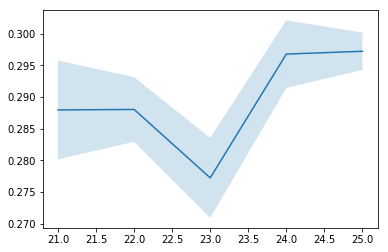

In [141]:
cvmean = model.cv_results_['mean_test_score']
cvstd = model.cv_results_['std_test_score']

plt.plot(ntopics_list, cvmean)
cvse = cvstd/np.sqrt(10)
plt.fill_between(ntopics_list, cvmean+cvse, cvmean-cvse,alpha=.2)

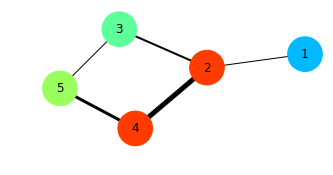

In [285]:
# toy graph for ppt

g2 = nx.Graph()
g2.add_edge(4, 2, weight=5)
g2.add_edge(2, 3, weight=2)
g2.add_edge(4, 5, weight=3)
g2.add_edge(2, 1, weight=1)
g2.add_edge(3, 5, weight=1)

strength = dict(g2.degree(weight='weight'))
values = [strength.get(node, 0.25) for node in g2.nodes()]
weights = [g2[u][v]['weight'] for u,v in g2.edges]

pos = nx.spring_layout(g2, weight=None)

fig = plt.figure(figsize=(4,2))
nx.draw(g2, pos, width=weights, node_size=1200, node_color=values, cmap='jet', vmin=-3, vmax=10, with_labels=True)
shortest_path(g2,1,5,weight="weight")
plt.savefig('shortpath_example.png')

In [286]:
shortest_path(g2,1,5,weight="weight")

[1, 2, 3, 5]